In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import scipy.optimize
import glob
import os
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'
from astropy.constants import G, M_sun, au

In [2]:
def cart_2_kep(x, y, z, vx, vy, vz):
    """
    Converts cartesian coordinates to Keplerian coordinates

    Parameters
    ----------
    x : float
        position (x-axis)
    y : float
        position (y-axis)
    z : float
        position (z-axis)
    vx : float
        velocity (x-axis) in AU/day' (must be multiplied by 0.01720209895 to be converted in AU/day)
    vy : float
        velocity (y-axis) in AU/day' (must be multiplied by 0.01720209895 to be converted in AU/day)
    vz : float
        velocity (z-axis) in AU/day' (must be multiplied by 0.01720209895 to be converted in AU/day)

    Returns
    -------
    a, e: float
        Keplerian coordinates of the protoplanets / planetesimals 

    """
    # Convert the units of the velocity from AU/day' to AU/day
    vx = vx * 0.01720209895
    vy = vy * 0.01720209895
    vz = vz * 0.01720209895
    
    # Compute the radius, r, and velocity v
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # Compute vector r and vector v
    r_vector = np.array([x, y, z])
    v_vector = np.array([vx, vy, vz])
    
    # Compute the specific angular momentum
    h_vector = np.cross(r_vector, v_vector)
    h = np.sqrt(h_vector[0]**2 + h_vector[1]**2 + h_vector[2]**2)
    
    # Compute the Standard gravitational parameter in AU/day
    mu_ms = G.value * M_sun.value # Standard gravitational parameter = GM of the central body
                                  # with G the Newtonian constant of gravitation (in m^3s^-2) 
    mu = mu_ms * (86400**2) / ((au.value)**3)    # There are 86400 s in a Julian day 
    
    # Compute the specific energy E
    E = ((v**2) / 2) - (mu / r)
    
    # Compute semi-major axis a
    a = - mu / (2 * E)
    
    # Compute eccentricity e
    e = np.sqrt(1 - (h**2 / (a * mu)))
    
    # Compute cosi
    cosi = h_vector[2]/h
    
    return a, e, cosi 

In [3]:
class body:
    time:np.ndarray
    a:np.ndarray
    e:np.ndarray
    cosi:np.ndarray
    x:np.ndarray
    y:np.ndarray
    z:np.ndarray
    vx:np.ndarray
    vy:np.ndarray
    vz:np.ndarray
    mass:np.ndarray
    
    def __init__(self, filename: str):
        # Load the data from the Out*.dat file
        data = np.loadtxt(filename)
        # If only one line in the Out*.dat, the data are not a 2-D list and the values
        # must be loaded differently
        if data.shape == (21,):
            self.time = np.asarray([data[0]])
            self.mass = np.asarray([data[2]])
            self.x = np.asarray([data[4]])
            self.y = np.asarray([data[5]])
            self.z = np.asarray([data[6]])
            self.vx = np.asarray([data[7]])
            self.vy = np.asarray([data[8]])
            self.vz = np.asarray([data[9]])
            
        else:
            self.time = data[:,0]
            self.mass = data[:,2]
            self.x = data[:,4]
            self.y = data[:,5]
            self.z = data[:,6]
            self.vx = data[:,7]
            self.vy = data[:,8]
            self.vz = data[:,9]

        #self.filename = filename
        self.filename = os.path.splitext(os.path.basename(filename))[0]
        self.len_time = len(self.time)
        self.a = np.zeros(self.len_time)
        self.e = np.zeros(self.len_time)
        self.cosi = np.zeros(self.len_time)
        for i in range(self.len_time):
            self.a[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[0]
            self.e[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[1]
            self.cosi[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[2]

In [5]:
# Initialize the body list
body_list = []

# Find the directory in which the data are stored and fetch all files from the directory
for filename in glob.glob('/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/1/Outclement_p*.dat', recursive=True):
    body_list.append(body(filename))

In [6]:
# Create a list with the remaining bodies at t = 100 Myr 
final_list = []
giant_list = np.array(['Outclement_p000000', 'Outclement_p000001', 'Outclement_p000002', 'Outclement_p000003', 'Outclement_p000004'])
for body in body_list:
    if body.len_time >= 4566 and body.mass[-1] > 1.0e-07 and body.filename not in giant_list: 
        final_list.append(body)

In [7]:
for body in final_list:
    print(body.a[-1])

1.5986149957681797
1.208380918031026
0.7421328525260948


In [8]:
# Calculate the angular momentum deficit in the inner SS
num_j_list = []
denom_j_list = []

for body in final_list:
    num_j = body.mass[-1] * np.sqrt(body.a[-1]) * (1 - (np.sqrt(1 - body.e[-1]**2) * body.cosi[-1]))
    denom_j = body.mass[-1] * np.sqrt(body.a[-1])
    num_j_list.append(num_j)
    denom_j_list.append(denom_j)
    
num = np.sum(num_j_list)
denom = np.sum(denom_j_list)
S_d = num / denom
print(S_d)

0.01402543215372871


In [482]:
# Calculation of the AMD for the present-day solar system (to compare the values)
mass_SS = np.array([1.651e-07, 2.447e-06, 3.00273e-6, 3.213e-07])
a_SS = np.array([0.387, 0.723, 1.000, 1.524])
e_SS = np.array([0.206, 0.0068, 0.0167, 0.0934])
cosi_SS = np.array([0.992546151641322, 0.9982398279237653, 1.0, 0.9994787687270248])

num_j_list = []
denom_j_list = []

for i in range(4):
    num_j = mass_SS[i] * np.sqrt(a_SS[i]) * (1 - (np.sqrt(1 - e_SS[i]**2) * cosi_SS[i]))
    denom_j = mass_SS[i] * np.sqrt(a_SS[i])
    num_j_list.append(num_j)
    denom_j_list.append(denom_j)
    
num = np.sum(num_j_list)
denom = np.sum(denom_j_list)
S_d = num / denom
print(S_d)

0.001615839990958571


In [9]:
# Calculate the radial mass concentration in the inner SS
def f(x):
    num_i_list = []
    denom_i_list = []
    for body in final_list:
        num_i = body.mass[-1]
        denom_i = body.mass[-1] * (np.log10(x/body.a[-1]))**2
        num_i_list.append(num_i)
        denom_i_list.append(denom_i)
    num = np.sum(num_i_list)
    denom = np.sum(denom_i_list)
    return num / denom

In [10]:
max_x = scipy.optimize.fmin(lambda x: -f(x), 0)
print(max_x)
print(f(max_x))

Optimization terminated successfully.
         Current function value: -87.652218
         Iterations: 24
         Function evaluations: 48
[0.8554375]
87.65221825556391


/var/folders/1r/d5kx07gd5nb7gwz3yz2rdp8m0000gn/T/ipykernel_85067/2751241391.py:7: RuntimeWarning: divide by zero encountered in log10
  denom_i = body.mass[-1] * (np.log10(x/body.a[-1]))**2


<IPython.core.display.Javascript object>


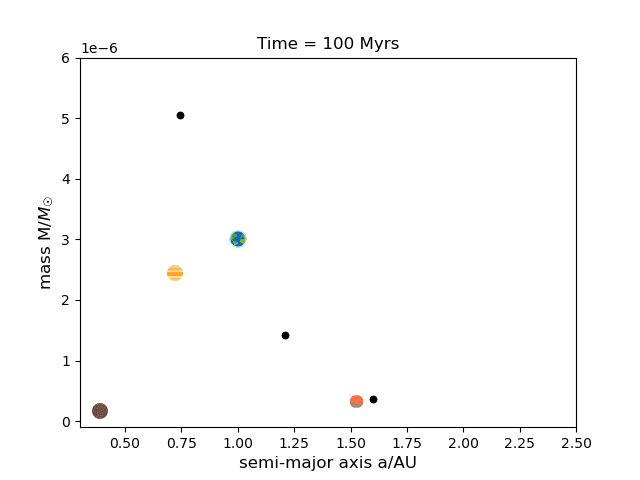

In [18]:
# -----------------------------------------------------------------------------------------------
# FIGURE 1bis: mass as a function of the semi major-axis at time = 100 Myr
# Go to genga_visu.py for the animated version of this plot
# -----------------------------------------------------------------------------------------------

# Create the figure
fig, ax = plt.subplots(figsize=(6.4, 4.8))
i = 4565 # last iteration
dt = 21902.80629705681 # interval of time in years
t = i * dt
#scatter = ax.scatter([body.a[i] for body in body_list],[body.mass[i] for body in body_list], c= 'black', marker='.')
ax.set_xlabel('semi-major axis a/AU', fontsize=12)
ax.set_ylabel('mass M/$M_\u2609$', fontsize=12)
ax.set_title('Time = 100 Myrs')
#ax.set_title('Time = ' + str(np.round(t/1000000, 3)) + ' Myrs')
ax.set_xlim(0.3, 2.5)
ax.set_ylim(-0.1e-6, 6.0e-6)
# For each body of the body list, take the semi-major axis of the corresponding 
# iteration time
a = [  body.a[i] if i < body.len_time else None   for body in body_list ]
# For each body of the body list, take the mass of the corresponding iteration time
M =  [  body.mass[i] if i < body.len_time else None   for body in body_list ]
#ax.scatter(a, M, c= 'black', marker='.')

#'''''''''''
# Insert images of the terrestrial  and giant planets
mercury = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/mercury.png')
venus = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/venus.png')
earth = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/earth.png')
mars = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/mars.png')

im_mercury = OffsetImage(mercury, zoom=0.3) 
im_venus = OffsetImage(venus, zoom=0.3)
im_earth = OffsetImage(earth, zoom=0.3)
im_mars = OffsetImage(mars, zoom=0.25)  

ab_me = AnnotationBbox(im_mercury, (0.387, 1.651e-7), frameon=False)
ab_ve = AnnotationBbox(im_venus, (0.723, 2.447e-6), frameon=False)
ab_ea = AnnotationBbox(im_earth, (1.0, 3.003e-6), frameon=False)
ab_ma = AnnotationBbox(im_mars, (1.524, 3.2e-7), frameon=False)

ax.add_artist(ab_me)
ax.add_artist(ab_ve)
ax.add_artist(ab_ea)
ax.add_artist(ab_ma)
#'''''''''''
ax.scatter(a, M, c= 'black', marker='.', s=85)

# Show the plot
plt.show()
# Save the fig
plt.savefig('/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/1/big_clement1.png', dpi=300)

<IPython.core.display.Javascript object>


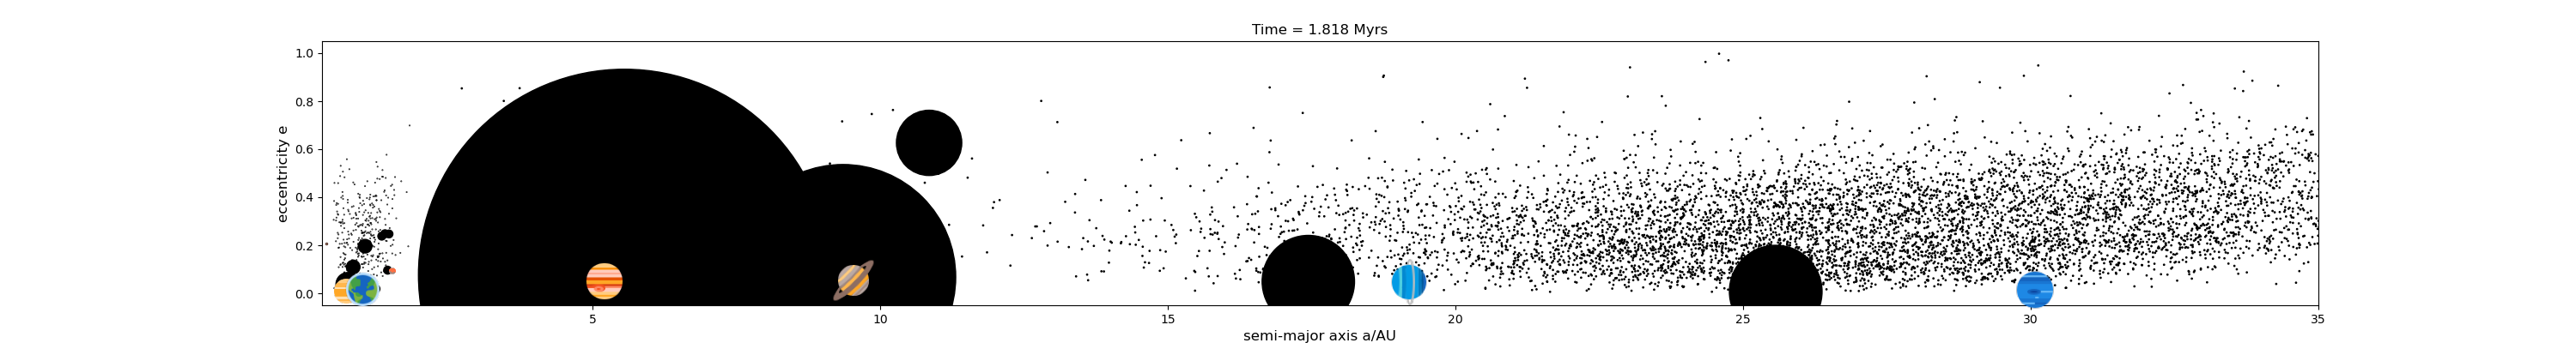

In [16]:
# -----------------------------------------------------------------------------------------------
# FIGURE 2: temporal evolution of the eccentricity as a function of the semi major-axis
# -----------------------------------------------------------------------------------------------
# Create the figure
#fig2, ax2 = plt.subplots()
fig2, ax2 = plt.subplots(figsize=(30, 4))

a_0 = [body.a[0] for body in body_list]
e_0 = [body.e[0] for body in body_list]
ax2.scatter(a_0, e_0, c= 'black', marker='.')
ax2.set_xlabel('semi-major axis a/AU', fontsize=12)
ax2.set_ylabel('eccentricity e', fontsize=12)
ax2.set_title('Time = 0 Myrs')
#ax2.set_xscale('log')
ax2.set_xlim(0.3, 35)
ax2.set_ylim(-0.05, 1.05)

# Define the interval of time for the animation
dt = 21902.80629705681 # in years

# Animation function
def animate2(j):
    
    # Clear the plot for each iteration
    ax2.clear()
    
    # iteration of time
    t = j * dt
    
    # Insert images of the terrestrial and giant planets
    mercury = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/mercury.png')
    venus = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/venus.png')
    earth = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/earth.png')
    mars = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/mars.png')
    jupiter = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/jupiter.png')
    saturn = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/saturn.png')
    uranus = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/uranus.png')
    neptune = mpimg.imread('/Users/sarahjoiret/Desktop/images/icons/neptune.png')

    im_mercury = OffsetImage(mercury, zoom=0.4*0.18) # should be *0.09 to be on scale 
    im_venus = OffsetImage(venus, zoom=0.4*1.37)
    im_earth = OffsetImage(earth, zoom=0.4*1.67)
    im_mars = OffsetImage(mars, zoom=0.4*0.36)  # should be *0.18 to be on scale 
    im_jupiter = OffsetImage(jupiter, zoom=0.4*2)
    im_saturn = OffsetImage(saturn, zoom=0.4*2)
    im_uranus = OffsetImage(uranus, zoom=0.4*2)
    im_neptune = OffsetImage(neptune, zoom=0.4*2)

    ab_me = AnnotationBbox(im_mercury, (0.387, 0.2056), frameon=False)
    ab_ve = AnnotationBbox(im_venus, (0.723, 0.0068), frameon=False)
    ab_ea = AnnotationBbox(im_earth, (1.0, 0.01671), frameon=False)
    ab_ma = AnnotationBbox(im_mars, (1.524, 0.0935), frameon=False)
    ab_ju = AnnotationBbox(im_jupiter, (5.2029, 0.0485), frameon=False)
    ab_sa = AnnotationBbox(im_saturn, (9.537, 0.0529), frameon=False)
    ab_ur = AnnotationBbox(im_uranus, (19.189, 0.0438), frameon=False)
    ab_ne = AnnotationBbox(im_neptune, (30.07, 0.0144), frameon=False)
     
    ax2.add_artist(ab_me)
    ax2.add_artist(ab_ve)
    ax2.add_artist(ab_ea)
    ax2.add_artist(ab_ma)
    ax2.add_artist(ab_ju)
    ax2.add_artist(ab_sa)
    ax2.add_artist(ab_ur)
    ax2.add_artist(ab_ne)
    
    # For each body of the body list, take the semi-major axis of the corresponding 
    # iteration time
    a_none = [  body.a[j] if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    a = []
    for val_a in a_none:
        if val_a != None :
            a.append(val_a)

    # For each body of the body list, take the eccentricity of the corresponding iteration time
    e_none =  [  body.e[j] if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    e = []
    for val_e in e_none:
        if val_e != None :
            e.append(val_e)
    
    # For each body of the body list, take the mass of the corresponding iteration time
    M_none =  [  body.mass[j] * 5e8 if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    M = []
    for val_M in M_none:
        if val_M != None :
            M.append(val_M)
            print(val_M)
    # Plotting the planetesimals 
    ax2.set_xlabel('semi-major axis a/AU', fontsize=12)
    ax2.set_ylabel('eccentricity e', fontsize=12)
    #ax2.set_xscale('log')
    ax2.set_xlim(0.3, 35)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_title('Time = ' + str(np.round(t/1000000, 3)) + ' Myrs')
    ax2.scatter(a, e, c= 'black', s=M, marker='.')

# Call the animation
ani2 = FuncAnimation(fig2, animate2, frames=10001, interval=100, repeat=True)

# Show the animated plot
plt.show()

<IPython.core.display.Javascript object>


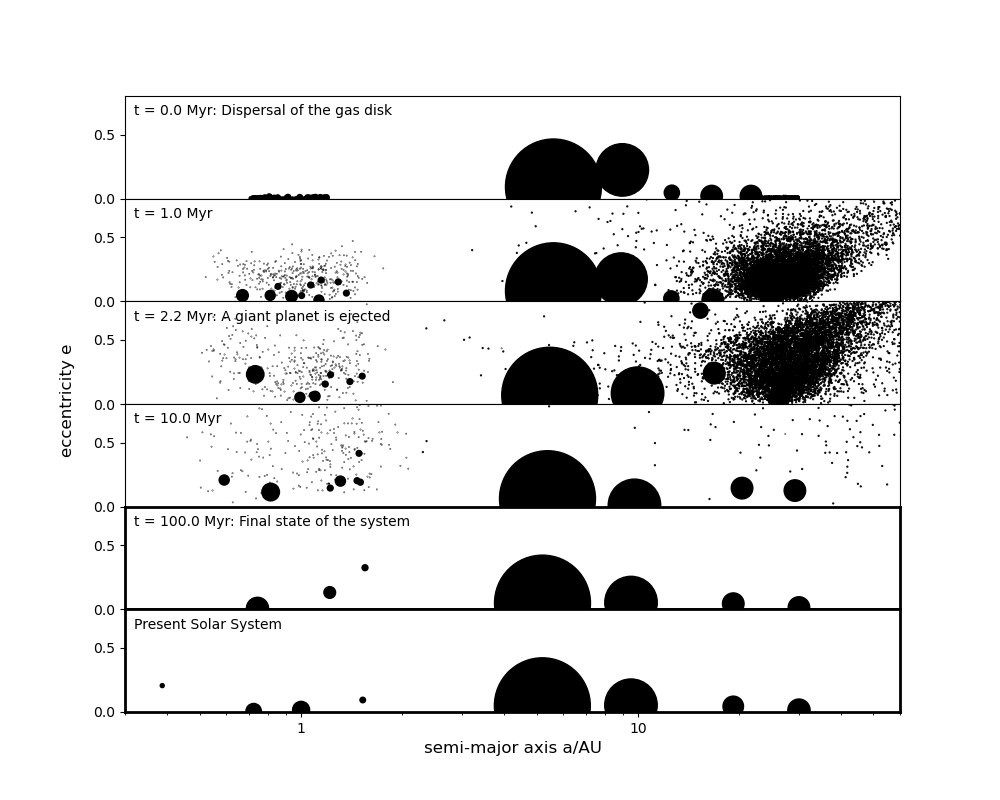

In [140]:
# -----------------------------------------------------------------------------------------------
# FIGURE 2bis: temporal evolution of the eccentricity as a function of the semi major-axis
# -----------------------------------------------------------------------------------------------
# Create the figure
#fig = plt.figure(figsize=(10, 2))
fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,8))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
plt.xscale('log')
plt.xlim(0.3, 60)
plt.ylim(0.0, 0.8)
plt.xticks([1,10], ['1', '10'])
plt.xlabel('semi-major axis a/AU', fontsize=12)
#for ax in axs:
#    ax.set_ylabel('eccentricity e')
fig.supylabel('eccentricity e', x=0.06, y=0.5, fontsize=12)

for j in range(4565):
    dt = 21902.80629705681 # in years
    # iteration of time
    t = j * dt
    
    # For each body of the body list, take the semi-major axis of the corresponding 
    # iteration time
    a_none = [  body.a[j] if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    a = []
    for val_a in a_none:
        if val_a != None :
            a.append(val_a)

    # For each body of the body list, take the eccentricity of the corresponding iteration time
    e_none =  [  body.e[j] if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    e = []
    for val_e in e_none:
        if val_e != None :
            e.append(val_e)
    
    # For each body of the body list, take the mass of the corresponding iteration time
    M_none =  [  body.mass[j] if j < body.len_time else None   for body in body_list ]
    # Remove the "None" values
    M = []
    for val_M in M_none:
        if val_M != None :
            M.append(val_M)
    
    # increase the size of the planetesimals (but not in the same way for the giant planets)
    for i in range(len(M)):
        if M[i] > 1e-5:
            xx = M[i]
            M[i] = xx * 0.2e8
        else:
            yy = M[i]
            M[i] = yy * 2e8
    
    if j == 0:
        axs[0].scatter(a, e, c= 'black', s=M, marker='.')
        axs[0].text(.32, .65, 't = ' + str(np.round(t/1000000, 1)) + ' Myr: Dispersal of the gas disk')
    
    if j == 45:
        axs[1].scatter(a, e, c= 'black', s=M, marker='.')
        axs[1].text(.32, .65, 't = ' + str(np.round(t/1000000, 1)) + ' Myr')
        
    if j == 100:
        axs[2].scatter(a, e, c= 'black', s=M, marker='.')
        axs[2].text(.32, .65, 't = ' + str(np.round(t/1000000, 1)) + ' Myr: A giant planet is ejected')
    
    if j == 456:
        axs[3].scatter(a, e, c= 'black', s=M, marker='.')
        axs[3].text(.32, .65, 't = ' + str(np.round(t/1000000, 1)) + ' Myr')
    
    if j == 4564:
        axs[4].scatter(a, e, c= 'black', s=M, marker='.')
        axs[4].text(.32, .65, 't = ' + str(np.round(t/1000000, 1)) + ' Myr: Final state of the system')
        for axis in ['top','bottom','left','right']:
            axs[4].spines[axis].set_linewidth(2)

# Present solar system
a_SS = np.array([0.387, 0.723, 1.0, 1.524, 5.2029, 9.537, 19.189, 30.07])
e_SS = np.array([0.2056, 0.0068, 0.01671, 0.0935, 0.0485, 0.0529, 0.0438, 0.0144])
M_SS = np.array([1.651*20, 24.47*20, 30.027*20, 3.213*20, 95.4588*200, 28.57*200, 4.365*200, 5.149*200])
axs[5].scatter(a_SS, e_SS, c= 'black', s=M_SS, marker='.')
axs[5].text(.32, .65, 'Present Solar System')
for axis in ['top','bottom','left','right']:
            axs[5].spines[axis].set_linewidth(2)

plt.show()
plt.savefig('/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/1/big_cl_evol1.png', dpi=300)